In [ ]:
!pip install yfinance
!pip install transformers
!pip install pytorch-lightning
!pip install wandb
!pip install pmdarima

# Collecting data

In [ ]:
!tar -xvzf bloomberg_news.tar.gz

20061020_20131126_bloomberg_news/2012-01-09/eravance-plunges-after-glaxo-partnered-drug-fails-in-tria
20061020_20131126_bloomberg_news/2012-01-09/ouis-dreyfus-looks-at-wind-power-with-edf-gdf-suez-echos-says
20061020_20131126_bloomberg_news/2012-01-09/copper-declines-as-europe-crisis-may-damp-demand-lme-preview
20061020_20131126_bloomberg_news/2012-01-09/clean-water-act-tool-used-by-epa-questioned-at-high-court-1-
20061020_20131126_bloomberg_news/2012-01-09/france-telecom-sells-900-million-5-375-30-year-notes
20061020_20131126_bloomberg_news/2012-01-09/exico-s-obrador-woos-business-with-lula-style-makeover-to-close-voter-gap
20061020_20131126_bloomberg_news/2012-01-09/ecb-financing-to-portuguese-lenders-rose-to-46-billion-euros-in-december
20061020_20131126_bloomberg_news/2012-01-09/philips-samsung-nintendo-righthaven-intellectual-property
20061020_20131126_bloomberg_news/2012-01-09/dollar-longs-are-the-most-extreme-since-2010-morgan-stanley-s-tse-says
20061020_20131126_bloomberg_news/

In [ ]:
!tar -xvf reuters_news.tar.bz2

reuters/
reuters/20070627.tsv
reuters/20131109.tsv
reuters/20160420.tsv
reuters/20140928.tsv
reuters/20130217.tsv
reuters/20130203.tsv
reuters/20140914.tsv
reuters/20160408.tsv
reuters/20131121.tsv
reuters/20090923.tsv
reuters/20100317.tsv
reuters/20110104.tsv
reuters/20090710.tsv
reuters/20150520.tsv
reuters/20080503.tsv
reuters/20101009.tsv
reuters/20100303.tsv
reuters/20110110.tsv
reuters/20140727.tsv
reuters/20090704.tsv
reuters/20080517.tsv
reuters/20070828.tsv
reuters/20111226.tsv
reuters/20101021.tsv
reuters/20150508.tsv
reuters/20070814.tsv
reuters/20120206.tsv
reuters/20121118.tsv
reuters/20160622.tsv
reuters/20070425.tsv
reuters/20120212.tsv
reuters/20150905.tsv
reuters/20080926.tsv
reuters/20121124.tsv
reuters/20070419.tsv
reuters/20150911.tsv
reuters/20121130.tsv
reuters/20080701.tsv
reuters/20150722.tsv
reuters/20111018.tsv
reuters/20140531.tsv
reuters/20090512.tsv
reuters/20110306.tsv
reuters/20100115.tsv
reuters/20080715.tsv
reuters/20090506.tsv
reuters/20140525.tsv
reut

In [ ]:
bloom_dates = [x[0].split('/')[-1] for x in os.walk('bloomberg')]
bloom_dates = sorted(bloom_dates[1:])

reuter_dates = [f.split('.')[0] for f in os.listdir('reuters') if os.path.isfile(os.path.join('reuters', f))]
#reuter_dates = [datetime.datetime.strptime(d, "%Y%m%d").date().strftime('%Y-%m-%d') for d in reuter_dates]
reuter_dates = [d[:4] + '-' + d[4:6] + '-' + d[6:] for d in sorted(reuter_dates)]

In [ ]:
class BloombergDataReader:
    
    def __init__(self, bloomberg_path):
        self.path = bloomberg_path
        self.dates = [x[0].split('/')[-1] for x in os.walk(bloomberg_path)]
        self.dates = sorted(self.dates[1:])
        
    def get_news_by_date(self, date):
        path = self.path + date + '/'
        news_files = [f.split('.')[0] for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        news = []
        for file in news_files:
            with open(path + file, 'r') as f:
                news.append(f.read())
        return news
    
    
class ReutersDataReader:
    
    def __init__(self, reuters_path):
        self.path = reuters_path
        self.dates = [f.split('.')[0] for f in os.listdir(reuters_path) if os.path.isfile(os.path.join(reuters_path, f))]
        self.dates = [d[:4] + '-' + d[4:6] + '-' + d[6:] for d in sorted(self.dates)]
        
    def get_news_by_date(self, date):
        path = self.path + date.replace('-', '') + '.tsv'
        try:
            frame = pd.read_csv(path, sep='\t')
        except:
            print(f'Error loading data from {path}')
        return frame['title']

In [ ]:
bloom_ds = BloombergDataReader('bloomberg/')
reuters_ds = ReutersDataReader('reuters/')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import re
import string

class TextDataset:
    
    def __init__(self, bllom_ds, reut_ds):
        self.bloomberg_ds = bloom_ds
        self.reuters_ds = reut_ds
        self.bloom_dates = set(bloom_ds.dates)
        self.reut_dates = set(reut_ds.dates)
        self.all_dates = self.bloom_dates.union(self.reut_dates)
        self.companies = {'^GSPC': ['s&p 500'], 
                          'MSFT': ['microsoft', 'msft'], 
                          'IBM': ['ibm'], 
                          '2318.HK': ['china'], 
                          '000001.SS': ['shanghai composite index']}
        
    def preprocess_sentence(self, sentence):
        new_sent = re.sub(f'[\W]', ' ', sentence)
        new_sent = re.sub(f'[{string.whitespace}]+', ' ', new_sent)
        return new_sent
        
    def filter_news_by_comp(self, news, comp):
        comp_names = self.companies[comp]
        new_sents = []
        for new in news:
            try:
                news_sents = new.lower().split(', ')
            except:
                continue
            for sent in news_sents:
                for name in comp_names:
                    if name.lower() in sent and len(sent.split(' ')) > 1:
                        new_sents.append(self.preprocess_sentence(sent))
        return new_sents
        
    def get_news_by_date_and_comp(self, date, comp):
        
        if date in self.bloom_dates:
            bloom_news = self.bloomberg_ds.get_news_by_date(date)
            bloom_news = self.filter_news_by_comp(bloom_news, comp)
        else:
            bloom_news = []
        
        if date in self.reut_dates:
            reut_news = self.reuters_ds.get_news_by_date(date)
            reut_news = self.filter_news_by_comp(reut_news, comp)
        else:
            reut_news = []
        
        return bloom_news + reut_news

In [ ]:
text_ds = TextDataset(bloom_ds, reuters_ds)

In [ ]:
import yfinance as yf
import pandas as pd

def get_hist_by_date_and_comp(date, comp):
    msft = yf.Ticker("MSFT")
    ds = msft.history(period='max')
    ds = ds[ds.index == date]
    print(ds)

comps = ['^GSPC', 'MSFT', 'IBM', '2318.HK', '000001.SS']
dates_to_del = []

for comp in comps:
    data = yf.Ticker(comp)
    ds = data.history(period='max')
    rows = []
    for date in text_ds.all_dates:
        row = ds[ds.index == date]
        rows.append(row)
        if len(row) == 0:
            dates_to_del.append(date)
    comp_frame = pd.concat(rows, axis=0).sort_index()
    comp_frame.to_csv(f'{comp}.tsv', sep='\t')

In [ ]:
comp_names = ['s&p 500', 'microsoft', 'ibm', 'china', 'shanghai composite index']

In [ ]:
for comp, comp_name in tqdm(zip(comps, comp_names)):
    frame = pd.read_csv(f'{comp}.tsv', '\t')
    new_frame = frame.copy()
    frame_news = []
    for date in frame['Date']:
        news = text_ds.get_news_by_date_and_comp(date, comp)
        if len(news) == 0:
            new_frame = new_frame[new_frame['Date'] != date]
            continue
        frame_news.append(news)
    new_frame['texts'] = frame_news
    new_frame.to_csv(f'{comp}_news.tsv', sep='\t')

# Data preprocessing test

In [45]:
import pandas as pd

frame = pd.read_csv('^GSPC_news.tsv', '\t')
frame.head()

Unnamed: 0  ...                                              texts
0         193  ...  ['has dropped 2 3 percent this year through ye...
1         307  ...  ['rallied after bear stearns cos advised buyin...
2         512  ...  ['he said the s p 500 is expected to end this ...
3         757  ...  ['it is a mincing why do it buffett has just g...
4         835  ...  ['cohen buys and sells minis says one former e...

[5 rows x 10 columns]

In [47]:
frame['Date'] = frame['Date'].astype('datetime64[ns]')
frame = frame.set_index(frame['Date']).drop(['Unnamed: 0', 'Date', 'Dividends', 'Stock Splits'], axis=1)

In [48]:
frame

Open  ...                                              texts
Date                     ...                                                   
2007-08-09  1497.209961  ...  ['has dropped 2 3 percent this year through ye...
2008-01-23  1310.410034  ...  ['rallied after bear stearns cos advised buyin...
2008-11-12   893.390015  ...  ['he said the s p 500 is expected to end this ...
2009-11-03  1040.920044  ...  ['it is a mincing why do it buffett has just g...
2010-02-26  1103.099976  ...  ['cohen buys and sells minis says one former e...
...                 ...  ...                                                ...
2013-11-19  1790.790039  ...  ['the s p 500 index climbed 3 2 percent that c...
2013-11-20  1789.589966  ...  ['loosen family planning rules and expand farm...
2013-11-21  1783.520020  ...  ['as gasoline and oil rallied while gold and s...
2013-11-22  1797.209961  ...  [' s p 500 posts for seventh weekly gain as dr...
2013-11-25  1806.329956  ...  ['but nothing i can point out as insane even t...

[813 rows x 6 columns]

In [40]:
mask = []
for i, row in frame.iterrows():
    mask.append(len(eval(row['texts'])) > 10)
    
sum(mask)

750

In [ ]:
frame = frame[mask]

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

frame = scaler.fit_transform(frame.drop('texts', axis=1))

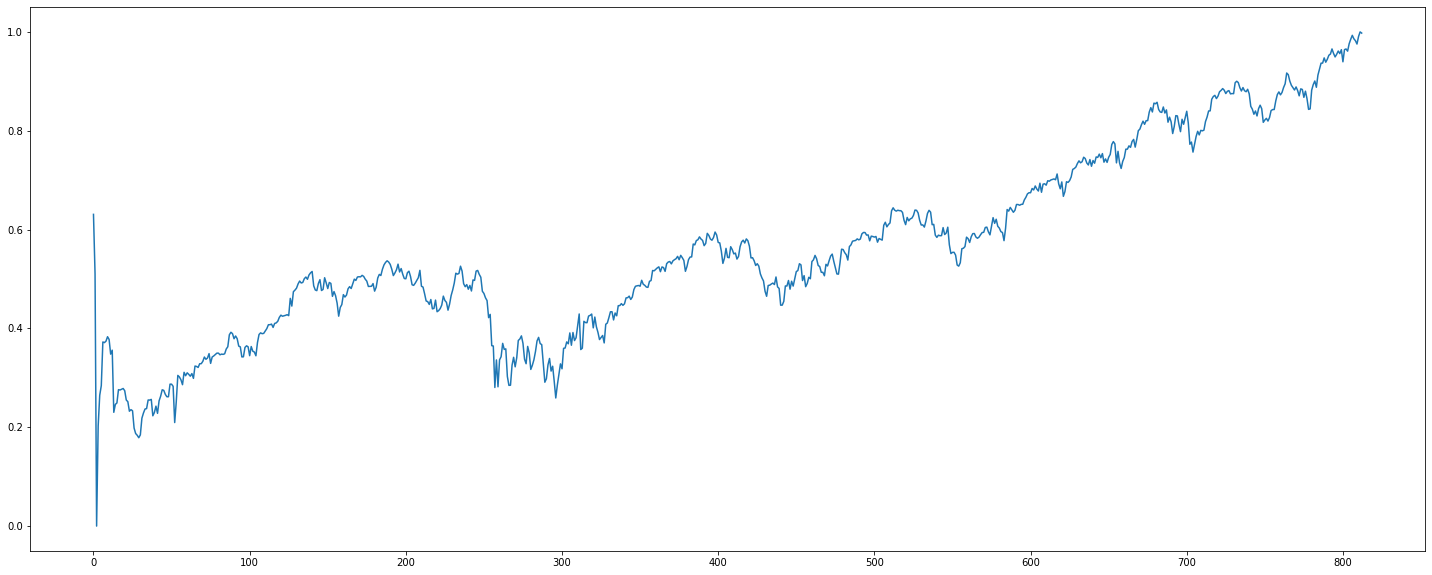

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))

plt.plot(np.arange(frame.shape[0]), frame[:, -2])

In [ ]:
deltas = []
for i in range(len(dates) - 1):
    deltas.append((dates[i+1] - dates[i]).days)

In [63]:
data = yf.Ticker('^GSPC')
ds = data.history(period='max')

In [64]:
ds = ds.drop(['Dividends', 'Stock Splits'], axis=1)

In [65]:
ds.index

DatetimeIndex(['1927-12-30', '1928-01-03', '1928-01-04', '1928-01-05',
               '1928-01-06', '1928-01-09', '1928-01-10', '1928-01-11',
               '1928-01-12', '1928-01-13',
               ...
               '2021-05-14', '2021-05-17', '2021-05-18', '2021-05-19',
               '2021-05-20', '2021-05-21', '2021-05-24', '2021-05-25',
               '2021-05-26', '2021-05-27'],
              dtype='datetime64[ns]', name='Date', length=23463, freq=None)

In [66]:
ds['texts'] = ['[]' for _ in range(len(ds))]

In [67]:
mask = []
for ind in ds.index:
    mask.append(ind not in frame.index)

In [68]:
df = frame.append([ds[mask]])

In [69]:
df = df.sort_index()

In [70]:
df = df[df.index > datetime.strptime('2010-01-01', '%Y-%m-%d')]
df = df[df.index < datetime.strptime('2014-01-01', '%Y-%m-%d')]

In [45]:
dates_msn = (datetime.strptime('2006-08-01', '%Y-%m-%d'), datetime.strptime('2016-08-01', '%Y-%m-%d'))

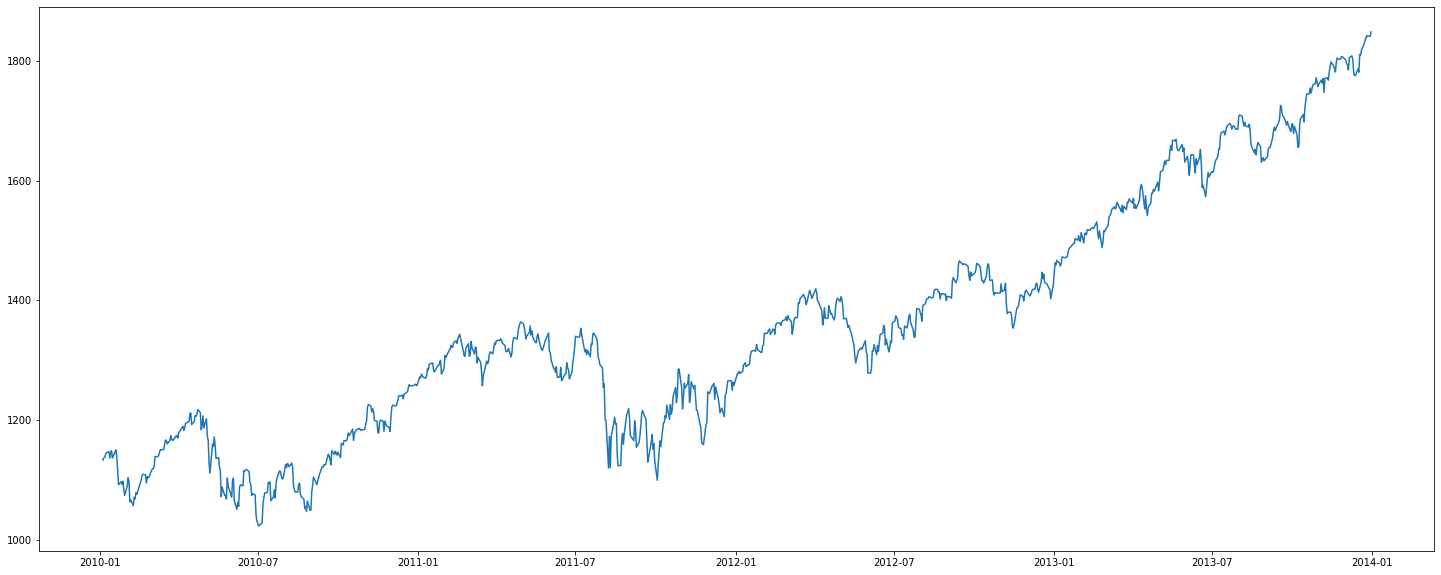

In [52]:
import matplotlib.pyplot as plt

from scipy.stats import boxcox

plt.figure(figsize=(25, 10))

from datetime import datetime, timedelta

#data = boxcox(df['Close'], lmbda=0)
data = np.array(df['Close'])

dif = data[1:] - data[:-1]

plt.plot(df.index, data)

In [71]:
df_new = df

In [72]:
text_num = []
for i, row in df_new.iterrows():
    text_num.append(len(eval(row['texts'])))

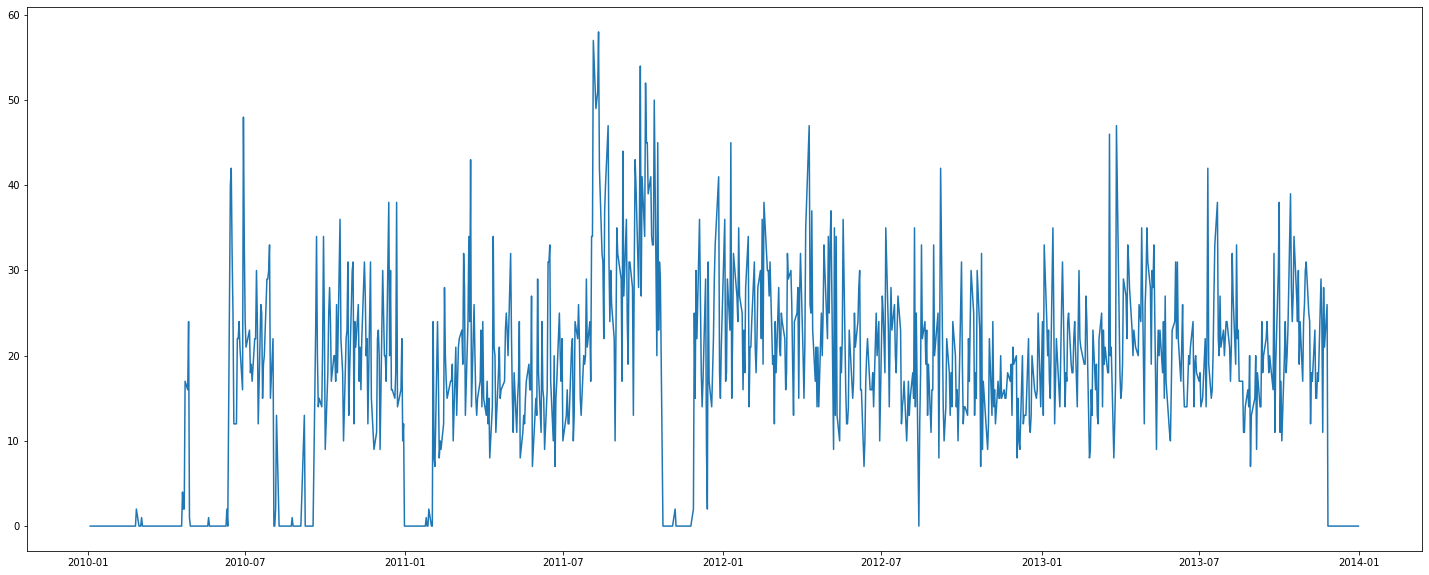

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))

from datetime import datetime

plt.plot(df_new.index, text_num)

In [ ]:
df_test.loc[datetime.strptime('2015-01-01', '%Y-%m-%d')] = [1842.609985, 1849.439941, 1842.410034, 1848.359985, 2312840000, []]

In [49]:
from datetime import datetime, timedelta

def check_correctness(dataframe):
    dates = dataframe.index
    deltas = []
    for i in range(len(dates) - 1):
        deltas.append((dates[i+1] - dates[i]).days)
    deltas = np.array(deltas)
    return np.all(deltas == 1)

def fill_spaces(df):
    df_new = df.copy()
    first_date = df_new.index[0]
    delta = df_new.index[-1] - first_date
    numdays = delta.days
    new_index = [first_date + timedelta(days=x) for x in range(numdays + 1)]
    for i in range(len(new_index) - 1):
        if new_index[i] not in df_new.index:
            df_new.loc[new_index[i]] = df_new.loc[new_index[i - 1]]
            df_new.loc[new_index[i]]['texts'] = '[]'
            df_new = df_new.sort_index()

    assert len(df_new) == len(new_index)

    return df_new

In [50]:
df.iloc[-1]

Open         1842.61
High         1849.44
Low          1842.41
Close        1848.36
Volume    2312840000
texts             []
Name: 2013-12-31 00:00:00, dtype: object

In [51]:
df_new = fill_spaces(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
len(df_new)

3650

# Data preprocessing

In [1]:
#!g1.1
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
#!g1.1

from datetime import datetime, timedelta
import yfinance as yf


def check_correctness(dataframe):
    dates = dataframe.index
    deltas = []
    for i in range(len(dates) - 1):
        deltas.append((dates[i+1] - dates[i]).days)
    deltas = np.array(deltas)
    return np.all(deltas == 1)

# Reads the data, enrich it with additional info and fills spaces
def read_and_preprocess_frame(name, from_date, to_date):
    #data_dir = 'drive/MyDrive/study/Skoltech/DL/final_project/gans/preprocessed/'
    data_dir = 'data/'
    frame = pd.read_csv(data_dir + f'{name}_news.tsv', '\t')

    frame['Date'] = frame['Date'].astype('datetime64[ns]')
    frame = frame.set_index(frame['Date']).drop(['Unnamed: 0', 'Date', 'Dividends', 'Stock Splits'], axis=1)

    data = yf.Ticker(name)
    ds = data.history(period='max')
    ds = ds.drop(['Dividends', 'Stock Splits'], axis=1)
    ds['texts'] = ['[]' for _ in range(len(ds))]

    mask = []
    for ind in ds.index:
        mask.append(ind not in frame.index)

    df = frame.append([ds[mask]]).sort_index()

    df = df[df.index > from_date]
    df = df[df.index < to_date]

    df = fill_spaces(df).reset_index()
    return df

# Fills spaces in dataframe with the past data
def fill_spaces(df):
    df_new = df.copy()
    first_date = df_new.index[0]
    delta = df_new.index[-1] - first_date
    numdays = delta.days
    new_index = [first_date + timedelta(days=x) for x in range(numdays + 1)]
    for i in range(len(new_index)):
        if new_index[i] not in df_new.index:
            df_new.loc[new_index[i]] = df_new.loc[new_index[i - 1]]
            df_new.loc[new_index[i]]['texts'] = '[]'
            df_new = df_new.sort_index()

    assert len(df_new) == len(new_index)

    return df_new

# This function filters dataframe records with less than min_news texts
def filter_dataframe(dataframe, min_news):
    mask = []
    for i, row in dataframe.iterrows():
        mask.append(len(eval(row['texts'])) > min_news)
    return dataframe[mask]
    
def check_week(deltas, count):
    if len(deltas) == 5:
        return count + (deltas[0] == deltas[1] == deltas[2] == deltas[3] == 1 and deltas[4] == 3)
    elif len(deltas) <= 4:
        return count + (sum(deltas) == len(deltas))
    
    if deltas[0] == deltas[1] == deltas[2] == deltas[3] == 1 and deltas[4] == 3:
        return check_week(deltas[5:], count + 1)
    else:
        return count
    
# This function determines the dates of start and end for all correct pieces with at least one week length
def determine_correct_weeks(dates):
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates]
       
    deltas = []
    for i in range(len(dates) - 1):
        deltas.append((dates[i+1] - dates[i]).days)
        
    dates_start = []
    dates_end = []
    for i in range(len(deltas) - 5):
        num_weeks = check_week(deltas[i:], 0)
        if num_weeks > 0:
            date_start = dates[i]
            if i + 5*num_weeks < len(dates):
                date_end = dates[i + 5*num_weeks]
            else:
                date_end = dates[-1]
            if date_end not in dates_end:
                dates_start.append(date_start)
                dates_end.append(date_end)
                    
    return dates_start, dates_end
    
# Dataframe contains spaces (in terms of dates, for example we don't have data for several dates) 
# so we need to select parts of it without spaces to keep timeseries structure
# It's exactly the purpose of this function
def split_frame_into_correct_pieces(dataframe, n_features, forecast_len):
    dates_start, dates_end = determine_correct_weeks(dataframe['Date'])
        
    subframes = []
    for date_start, date_end in zip(dates_start, dates_end):
        date_start = date_start.strftime('%Y-%m-%d')
        date_end = date_end.strftime('%Y-%m-%d')
        mask = np.logical_and(dataframe['Date'] >= date_start, dataframe['Date'] < date_end)
        if sum(mask) - n_features - forecast_len > 0:
            subframes.append(dataframe[mask])
            #print(sum(mask) - n_features - forecast_len)
            
    return subframes

In [7]:
#!g1.1
import os
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification


class StockAndTextDataset(Dataset):
    
    def __init__(self, subframes, n_features, forecast_len, num_texts, scaler=None):
        self.n_features = n_features
        self.forecast_len = forecast_len
        self.scaler = scaler
        
        self.data = [self.generate_dataframe_features(df) for df in subframes]
        self.batch_counts = [len(i) - n_features - forecast_len + 1 for i in self.data]
        
        tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")
        sent_model = AutoModelForSequenceClassification.from_pretrained("avichr/heBERT_sentiment_analysis").to(device)

        all_texts = []
        for frame in subframes:
            for text_list in frame['texts']:
                all_texts += eval(text_list)
        self.all_texts = set(all_texts)
        self.texts_sentiments = self._precompute_scores_for_texts(list(self.all_texts), sent_model, tokenizer)


        del sent_model, tokenizer
        
        self.num_texts = num_texts # Number of texts which will be taken as most confidently classified by sentiment model
        
    def __len__(self):
        return sum(self.batch_counts)

    def exp_smooth(self, data, alpha):
        new_data = [data[0]]
        for d in data:
            new_data.append(d * alpha + new_data[-1] * (1 - alpha))
        return new_data[1:]

    def moving_avg(self, data, window):
        new_data = []
        for i in range(len(data)):
            start = i - window + 1 if i >= window else 0
            end = i + 1
            array = data[start:end]
            new_data.append(np.mean(array))
        return new_data

    def compute_EMA(self, data, period):
        pass

    def generate_dataframe_features(self, df):

        df[['Open', 'High', 'Low', 'Close', 'Volume']] = self.scale_features(df[['Open', 'High', 'Low', 'Close', 'Volume']].values)
        #df = df.drop('Volume', axis=1)

        data = np.array(df['Close'])
        df['exp_smooth'] = self.exp_smooth(data, 0.5)
        df['moving_avg_7'] = self.moving_avg(data, 7)
        df['moving_avg_21'] = self.moving_avg(data, 13)

        steps = np.arange(len(data))
        plt.plot(steps, data, label='True data')
        plt.plot(steps, df['exp_smooth'], label='Exp smooth')
        plt.plot(steps, df['moving_avg_7'], label='Moving average 7')
        plt.plot(steps, df['moving_avg_21'], label='Moving average 21')
        plt.legend()

        return df

    def _precompute_scores_for_texts(self, texts, sent_model, tokenizer):
        res = {}
        batch_size = 10
        batch_num = len(texts) // batch_size + 1 if len(texts) % batch_size > 0 else len(texts) // batch_size

        with torch.no_grad():
            for i in range(batch_num):

                batch = texts[i*batch_size:(i+1)*batch_size]
                bert_inp = tokenizer(batch, padding='max_length', truncation=True, max_length=512)
                ids = torch.from_numpy(np.array(bert_inp['input_ids'])).type(torch.LongTensor).to(device)
                masks = torch.from_numpy(np.array(bert_inp['attention_mask'])).type(torch.FloatTensor).to(device)

                result = sent_model(input_ids=ids, attention_mask=masks).logits

                scores, labels = result.max(dim=-1)
                scores, labels = scores.cpu().numpy().ravel(), labels.cpu().numpy().ravel()
                labels[labels == 2] = -1

                for j, text in enumerate(batch):
                    res[text] = (labels[j], scores[j])

        return res

    def scale_features(self, data):
        if self.scaler is None:
            self.scaler = MinMaxScaler()
            data = self.scaler.fit_transform(data)
        else:
            data = self.scaler.transform(data)
        return data
        
    def __getitem__(self, idx):
        
        cumsums = np.cumsum(self.batch_counts)
        for i, s in enumerate(cumsums):
            if s > idx:
                df = self.data[i]
                new_idx = idx - cumsums[i-1] if i > 0 else idx
                break
    
        features = df[new_idx:new_idx + self.n_features]
        target = df[new_idx + self.n_features:new_idx + self.n_features + self.forecast_len]['Close'].values

        assert np.all(np.array(target) < 2000)
        
        close_data, features, texts = features['Close'].values, features.drop(['texts', 'Date'], axis=1).values, features['texts']

        new_texts = []
        for text_list in texts:
            new_texts += eval(text_list)
        texts = set(new_texts)

        scores = sorted([self.texts_sentiments[t] for t in texts], key=lambda x: -x[1])
        sentiments = np.array([i[0] for i in scores[:self.num_texts]])

        sentiments = (sentiments - sentiments.mean()) / (sentiments.std() + 1e-10) # Normalisation for sentiment scores
        if len(sentiments) < self.num_texts:
            sentiments = np.pad(sentiments, (0, self.num_texts - len(sentiments)), 'constant')
        
        assert close_data.shape == (self.n_features,)
        assert features.shape == (self.n_features, 8)
        assert sentiments.shape == (self.num_texts,)
        assert target.shape == (self.forecast_len,)
        
        close_data = torch.from_numpy(close_data).type(torch.FloatTensor) # (n_features)
        features = torch.from_numpy(features).type(torch.FloatTensor) # (n_features, 8)
        sentiments = torch.from_numpy(sentiments).type(torch.FloatTensor) # (num_texts)
        target = torch.from_numpy(target).type(torch.FloatTensor) # (forecast_len)
        
        return close_data, features, sentiments, target

In [13]:
#!g1.1
import os
import json
import torch
import numpy as np
import pmdarima as pm
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# The difference with the previous dataset is that this dataset's target is the difference between the next and the current prices
class StockAndTextDataset_der(Dataset):
    
    def __init__(self, subframes, n_features, forecast_len, num_texts):
        self.n_features = n_features
        self.forecast_len = forecast_len
        
        self.data = [self.generate_dataframe_features(df) for df in subframes]
        self.batch_counts = [len(i) - n_features - forecast_len + 1 for i in self.data]
        
        tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")
        sent_model = AutoModelForSequenceClassification.from_pretrained("avichr/heBERT_sentiment_analysis").to(device)

        all_texts = []
        for frame in subframes:
            for text_list in frame['texts']:
                all_texts += eval(text_list)
        self.all_texts = set(all_texts)
        self.texts_sentiments = self._precompute_scores_for_texts(list(self.all_texts), sent_model, tokenizer)

        self.num_texts = num_texts # Number of texts which will be taken as most confidently classified by sentiment model
        
    def __len__(self):
        return sum(self.batch_counts)

    def exp_smooth(self, data, alpha):
        new_data = [data[0]]
        for d in data:
            new_data.append(d * alpha + new_data[-1] * (1 - alpha))
        return new_data[1:]

    def moving_avg(self, data, window):
        new_data = []
        for i in range(len(data)):
            start = i - window if i >= window else 0
            end = i + window
            array = data[start:end]
            new_data.append(np.mean(array))
        return new_data

    def derivatives(self, data):
        der = [0]
        for i in range(1, len(data)):
            der.append(data[i] - data[i-1])
        return der

    def generate_dataframe_features(self, df):
        
        close_data = np.array(df['Close'])
        df['exp_smooth'] = self.exp_smooth(close_data, 0.5)
        df['moving_avg_7'] = self.moving_avg(close_data, 3)
        df['moving_avg_21'] = self.moving_avg(close_data, 10)
        df['derivatives'] = self.derivatives(close_data)
 
        return df

    def _precompute_scores_for_texts(self, texts, sent_model, tokenizer):
        res = {}
        batch_size = 10
        batch_num = len(texts) // batch_size + 1 if len(texts) % batch_size > 0 else len(texts) // batch_size

        with torch.no_grad():
            for i in range(batch_num):

                batch = texts[i*batch_size:(i+1)*batch_size]
                bert_inp = tokenizer(batch, padding='max_length', truncation=True, max_length=512)
                ids = torch.from_numpy(np.array(bert_inp['input_ids'])).type(torch.LongTensor).to(device)
                masks = torch.from_numpy(np.array(bert_inp['attention_mask'])).type(torch.FloatTensor).to(device)

                result = sent_model(input_ids=ids, attention_mask=masks).logits

                scores, labels = result.max(dim=-1)
                scores, labels = scores.cpu().numpy().ravel(), labels.cpu().numpy().ravel()
                labels[labels == 2] = -1

                for j, text in enumerate(batch):
                    res[text] = (labels[j], scores[j])

        return res
        
    def __getitem__(self, idx):
        
        cumsums = np.cumsum(self.batch_counts)
        for i, s in enumerate(cumsums):
            if s > idx:
                df = self.data[i]
                new_idx = idx - cumsums[i-1] if i > 0 else idx
                break
    
        features = df[new_idx:new_idx + self.n_features]
        target = df[new_idx + self.n_features:new_idx + self.n_features + 1]['Close'].values
        
        close_data, features, texts = features['Close'].values, features.drop(['texts', 'Date'], axis=1).values, features['texts']

        new_texts = []
        for text_list in texts:
            new_texts += eval(text_list)
        texts = set(new_texts)

        scores = sorted([self.texts_sentiments[t] for t in texts], key=lambda x: -x[1])
        sentiments = np.array([i[0] for i in scores[:self.num_texts]])

        sentiments = (sentiments - sentiments.mean()) / (sentiments.std() + 1e-10) # Normalisation for sentiment scores
        if len(sentiments) < self.num_texts:
            sentiments = np.pad(sentiments, (0, self.num_texts - len(sentiments)), 'constant')
        
        assert close_data.shape == (self.n_features,)
        assert features.shape == (self.n_features, 9)
        assert sentiments.shape == (self.num_texts,)
        assert target.shape == (1,)

        target = target - close_data[-1]
        
        close_data = torch.from_numpy(close_data).type(torch.FloatTensor) # (n_features)
        features = torch.from_numpy(features).type(torch.FloatTensor) # (n_features, 6)
        sentiments = torch.from_numpy(sentiments).type(torch.FloatTensor) # (num_texts)
        target = torch.from_numpy(target).type(torch.FloatTensor) # (1,)
        
        return close_data, features, sentiments, target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

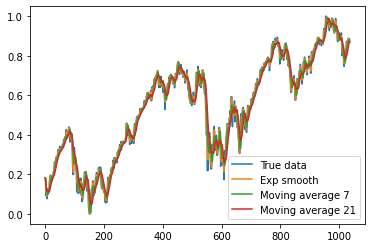

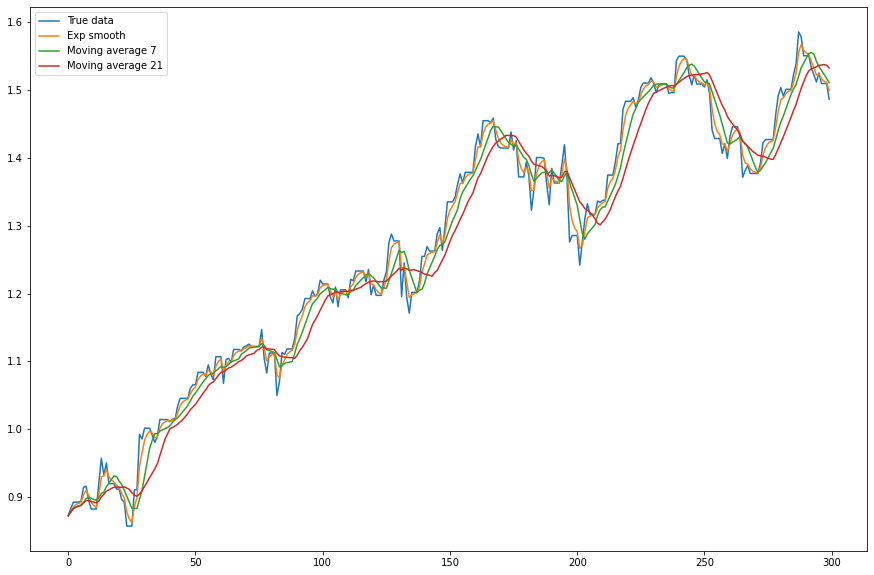

In [12]:
import matplotlib.pyplot as plt

# to work with another dataset just uncomment corresponding lines

dates_gsp = (datetime.strptime('2010-02-01', '%Y-%m-%d'), datetime.strptime('2013-10-01', '%Y-%m-%d'))
#dates_msn = (datetime.strptime('2007-01-01', '%Y-%m-%d'), datetime.strptime('2016-06-01', '%Y-%m-%d'))
#dates_chn = (datetime.strptime('2006-08-01', '%Y-%m-%d'), datetime.strptime('2016-08-01', '%Y-%m-%d'))
        
snp_df = read_and_preprocess_frame('^GSPC', *dates_gsp)
#ms_df = read_and_preprocess_frame('MSFT', *dates_msn)
#ch_df = read_and_preprocess_frame('2318.HK', *dates_chn)

train_frames = [snp_df[:-300]]#[ms_df[:-300], ch_df[:-300]]
val_frames = [snp_df[-300:]]#[ms_df[-300:], ch_df[-300:]]

train_dataset = StockAndTextDataset(train_frames, 12, 1, 100)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

plt.figure(figsize=(15, 10))
val_dataset = StockAndTextDataset(val_frames, 12, 1, 100, scaler=train_dataset.scaler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Model definition

In [37]:
#!g1.1
import wandb
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader


class StockPriceGenerator(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.):
        
        super(StockPriceGenerator, self).__init__()
    
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, proj_size=0)
        self.regressor = nn.Linear(hidden_size, 1)
        
    def forward(self, x, sent, forecast_len=1, return_last_only=True):
        h_t = sent.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_t = torch.zeros(h_t.shape).to(device)

        out, (h_t, c_t) = self.encoder(x, (h_t, c_t))

        if return_last_only:
            res = F.relu(out[:, -1, :])
        else:
            res = F.relu(out)

        return self.regressor(res)
    
class StockPriceDiscriminator(nn.Module):
    
    def __init__(self, kernel_size, stride=2):
        
        super(StockPriceDiscriminator, self).__init__()
        
        padding = kernel_size // 2
        self.convs = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.Conv1d(4, 16, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.Conv1d(16, 64, kernel_size=kernel_size, stride=stride, padding=padding),
        )
        self.flatten = nn.Flatten()
        self.projector = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        out = self.convs(x)
        out = self.flatten(out)
        #print(out.shape)
        return self.projector(out)

class GANLoss(nn.Module):
    """
    GAN loss calculator

    Variants:
      - non_saturating
      - hinge
    """
    def __init__(self, loss_type):
        super(GANLoss, self).__init__()
        self.loss_type = loss_type

    def forward(self, fake_scores, real_scores=None):
        if real_scores is None:
            # TODO: calculate generator loss (2 points)
            if self.loss_type == 'non_saturating':
                ones = torch.ones((fake_scores.shape[0],)).to(fake_scores.device)
                loss = nn.BCEWithLogitsLoss()(fake_scores, ones)
            elif self.loss_type == 'hinge':
                loss = -fake_scores.mean()
            else:
                raise Exception(f'Unknown loss type {self.loss_type}')

        else:
            # TODO: calculate discriminator loss (2 points)
            if self.loss_type == 'non_saturating':
                #fake_scores = torch.sigmoid(fake_scores)
                #real_scores = torch.sigmoid(real_scores)
                real_labels = torch.ones(real_scores.shape).to(real_scores.device)
                fake_labels = torch.zeros(real_scores.shape).to(real_scores.device)
                loss = nn.BCEWithLogitsLoss()(real_scores, real_labels) + nn.BCEWithLogitsLoss()(fake_scores, fake_labels)#-torch.log(real_scores + 1e-6).mean() - torch.log(1 - fake_scores + 1e-6).mean()
            elif self.loss_type == 'hinge':
                #zeros = torch.zeros(fake_scores.shape).to(fake_scores.device)
                loss = F.relu(1. - real_scores) + F.relu(1. + fake_scores)#-torch.minimum(zeros, -1 + real_scores) - torch.minimum(zeros, -1 - fake_scores)
                loss = loss.mean()
            else:
                raise Exception(f'Unknown loss type {self.loss_type}')

        return loss

class StockPriceGAN(LightningModule):
    
    def __init__(self, gen_input_size, gen_hidden_size, dis_kernel_size, dis_stride=2, train_loader=None, val_loader=None):
        
        super(StockPriceGAN, self).__init__()
        
        self.generator = StockPriceGenerator(gen_input_size, gen_hidden_size)
        self.discriminator = StockPriceDiscriminator(dis_kernel_size, dis_stride)

        # Empirically obtained values. In this interval we have enough texts and data to train model

        if train_loader is not None and val_loader is not None:
            self.train_loader = train_loader
            self.val_loader = val_loader

        else:
            # Empirically obtained values. In this interval we have enough texts and data to train model
            dates_gsp = (datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.strptime('2014-01-01', '%Y-%m-%d'))
            #dates_msn = (datetime.strptime('2007-01-01', '%Y-%m-%d'), datetime.strptime('2016-06-01', '%Y-%m-%d'))
            #dates_chn = (datetime.strptime('2006-08-01', '%Y-%m-%d'), datetime.strptime('2016-08-01', '%Y-%m-%d'))
        
            snp_df = read_and_preprocess_frame('^GSPC', *dates_gsp)
            #ms_df = read_and_preprocess_frame('MSFT', *dates_msn)
            #ch_df = read_and_preprocess_frame('2318.HK', *dates_chn)
        
            self.train_subframes = [snp_df[:-300]]#[ms_df[:-300], ch_df[:-300]]
            self.val_subframes = [snp_df[-300:]]#[ms_df[-300:], ch_df[-300:]]
            
            dataset = StockAndTextDataset(self.train_subframes, gen_input_size, 1, gen_hidden_size)
            #dataset = StockAndTextDataset(self.train_subframes, 128, self.gen_forecast_len, self.gen_hidden_size)
            self.train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

            dataset = StockAndTextDataset(self.val_subframes, gen_input_size, 1, gen_hidden_size)
            #dataset = StockAndTextDataset(self.val_subframes, 128, self.gen_forecast_len, self.gen_hidden_size)
            self.val_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

        self.criterion = GANLoss('hinge')
        
        self.gen_hidden_size = gen_hidden_size

        wandb.init(project='stock-price-prediction')
        
    def forward(self, data, sentiments):
        return self.generator(data, sentiments)

    def predict_val_data_for_plot(self, predict_for_n_batches=4):

        loader_iter = iter(self.val_loader)

        preds = []
        targets = []

        for _ in range(predict_for_n_batches):

            close_data, data, sentiment, target = next(loader_iter)

            close_data = torch.cat((close_data_1, close_data_2, close_data_3, close_data_4), dim=0).to(device)#.numpy()
            data = torch.cat((data_1, data_2, data_3, data_4), dim=0).to(device)
            sentiment = torch.cat((sentiment_1, sentiment_2, sentiment_3, sentiment_4), dim=0).to(device)
            target = torch.cat((target_1, target_2, target_3, target_4), dim=0).squeeze().numpy()

            #res = self.generator(close_data.unsqueeze(-1), sentiment, return_last_only=True).squeeze().cpu().numpy()
            res = self.generator(data, sentiment, return_last_only=True).squeeze().cpu().numpy()
            preds.append(res)
            targets.append(target)

        res = np.concatenate(preds)
        target = np.concatenate(targets)

        steps = np.arange(res.shape[0])

        scaler = self.train_loader.dataset.scaler

        target_with_ph = np.concatenate((target.reshape((-1, 1)), torch.zeros((target.shape[0], 4))), axis=1)
        unscaled_target = scaler.inverse_transform(target_with_ph)[:, 0].reshape(-1)

        res_with_ph = np.concatenate((res.reshape((-1, 1)), torch.zeros((target.shape[0], 4))), axis=1)
        unscaled_res = scaler.inverse_transform(res_with_ph)[:, 0].reshape(-1)

        plt.plot(steps, unscaled_target, label='True close price')
        plt.plot(steps, unscaled_res, label='1 step prediction')
        plt.legend()

        wandb.log({'128 steps prediction': plt})
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        
        close_data, data, sentiment, target = batch
        close_data, data, sentiment, target = close_data.to(device), data.to(device), sentiment.to(device), target.to(device)

        #print(close_data.shape)
        
        #res = self.generator(close_data.unsqueeze(-1), sentiment, return_last_only=True).reshape(target.shape)
        res = self.generator(data, sentiment, return_last_only=True).reshape(target.shape)
        fake_data = torch.cat((close_data, res), dim=1)

        true_data = torch.cat((close_data, target), dim=1)
        fake_scores = self.discriminator(fake_data.unsqueeze(1)).squeeze()

        wandb.log({'train_RMSE': torch.sqrt(((res - target) ** 2).mean()).item()})

        if optimizer_idx == 0:
            
            ### Optimizing Generator

            gen_loss = self.criterion(fake_scores)

            wandb.log({'gen_loss': gen_loss.item()})

            return gen_loss
        
        else:
        
            ### Optimizing Discriminator
        
            true_scores = self.discriminator(true_data.unsqueeze(1)).squeeze()
            dis_loss = self.criterion(fake_scores, true_scores)

            wandb.log({'dis_loss': dis_loss.item()})

            return dis_loss
    
    def validation_step(self, batch, batch_idx):

        close_data, data, sentiment, target = batch
        #preds = self.generator(close_data.unsqueeze(-1), sentiment).reshape(target.shape)
        preds = self.generator(data, sentiment).reshape(target.shape)
        loss = torch.sqrt(torch.mean((preds - target) ** 2))

        return loss.item()

    def validation_epoch_end(self, val_step_outputs):
        self.predict_val_data_for_plot(len(self.val_loader))
        wandb.log({'val_RMSE': np.array(val_step_outputs).mean()})
    
    def train_dataloader(self):
        return self.train_loader
    
    def val_dataloader(self):
        return self.val_loader
    
    def configure_optimizers(self):
        return [torch.optim.Adam(self.generator.parameters(), lr=1e-2), torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)], []

In [35]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [36]:
#!g1.1
from pytorch_lightning import Trainer

model = StockPriceGAN(8, 100, 5, train_loader=train_loader, val_loader=val_loader)
trainer = Trainer(gpus=1, max_epochs=500)#, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | generator     | StockPriceGenerator     | 124 K 
1 | discriminator | StockPriceDiscriminator | 15.9 K
2 | criterion     | GANLoss                 | 0     
----------------------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.563     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



# Baseline test

In [106]:
model = nn.LSTM(input_size=1, hidden_size=100, num_layers=2, batch_first=True).to(device)
proj = nn.Linear(100, 1).to(device)

In [107]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(proj.parameters()), lr=1e-4)

In [108]:
for p in model.parameters():
    p.requires_grad = True

In [109]:
for i in range(100):

    #model.train()
    for close_data, data, sentiment, target in train_loader:

        close_data, target = close_data.unsqueeze(-1).to(device), target.to(device)

        h_0 = torch.zeros(2, data.shape[0], model.hidden_size).to(device)
        c_0 = torch.zeros(h_0.shape).to(device)

        out, (h_t, c_t) = model(close_data, (h_0, c_0))
        res = proj(h_t[-1, :, :])

        loss = criterion(res, target)
        loss.backward()
        optimizer.step()

    #model.eval()
    with torch.no_grad():
        losses = []

        for close_data, data, sentiment, target in val_loader:

            close_data, target = close_data.unsqueeze(-1).to(device), target.to(device)

            h_0 = torch.zeros(2, data.shape[0], model.hidden_size).to(device)
            c_0 = torch.zeros(h_0.shape).to(device)

            out, (h_t, c_t) = model(close_data, (h_0, c_0))
            res = proj(h_t[-1, :, :])

            loss = criterion(res, target)    
            losses.append(loss.item())
        
        print(f'Epoch {i} \t val loss {np.mean(losses)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars

Exception in thread Thread-84:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 198, in check_status
    status_response = self._interfac

Epoch 0 	 val loss 0.7173750814464357
Epoch 1 	 val loss 0.5406061460574468
Epoch 2 	 val loss 0.9980767435497708
Epoch 3 	 val loss 0.8320571680863699
Epoch 4 	 val loss 0.42226309867368805
Epoch 5 	 val loss 0.1778748883969254
Epoch 6 	 val loss 0.4218240934941504
Epoch 7 	 val loss 0.6403701139820946
Epoch 8 	 val loss 0.6246689566307597
Epoch 9 	 val loss 0.4173952043056488
Epoch 10 	 val loss 0.14943860471248627
Epoch 11 	 val loss 0.0666158339784791
Epoch 12 	 val loss 0.17439001322620445
Epoch 13 	 val loss 0.2476079199049208
Epoch 14 	 val loss 0.20136770916481814
Epoch 15 	 val loss 0.121111241221014
Epoch 16 	 val loss 0.07381446884634595
Epoch 17 	 val loss 0.07981499186199573
Epoch 18 	 val loss 0.13266885415133503
Epoch 19 	 val loss 0.19084858521819115
Epoch 20 	 val loss 0.1918365297218164
Epoch 21 	 val loss 0.04443279722990054
Epoch 22 	 val loss 0.00633212070291241
Epoch 23 	 val loss 0.3131139891015159
Epoch 24 	 val loss 0.14715850498113367
Epoch 25 	 val loss 0.023

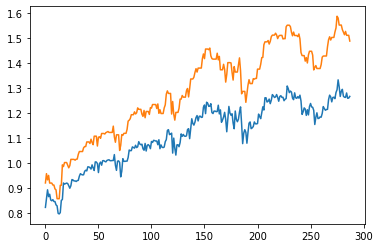

In [110]:
results = []
targets = []

for close_data, data, sentiment, target in val_loader:

    close_data, target = close_data.unsqueeze(-1).to(device), target.to(device)

    h_0 = torch.zeros(2, data.shape[0], model.hidden_size).to(device)
    c_0 = torch.zeros(h_0.shape).to(device)

    out, (h_t, c_t) = model(close_data, (h_0, c_0))
    res = proj(h_t[-1, :, :])

    results.append(res.squeeze())
    targets.append(target.squeeze())

results = torch.cat(results, dim=0).detach().cpu().numpy()
targets = torch.cat(targets, dim=0).detach().cpu().numpy()

plt.plot(results)
plt.plot(targets)